Let`s analyze how quickly the audience of our service is growing and examine the dynamics of the number of users and couriers.

Metrics to Calculate:
 - Number of new users.
 - Number of new couriers.
 - Total number of users for the current day.
 - Total number of couriers for the current day.

Definition of new users and couriers:
New users and couriers are those who performed their first action in the service on a given day. 
The total number of users/couriers for the current day is the sum of new users/couriers from all previous days.

```SQL
SELECT start_date as date,
       new_users,
       new_couriers,
       (sum(new_users) OVER (ORDER BY start_date))::int as total_users,
       (sum(new_couriers) OVER (ORDER BY start_date))::int as total_couriers
FROM   (SELECT start_date,
               count(courier_id) as new_couriers
        FROM   (SELECT courier_id,
                       min(time::date) as start_date
                FROM   courier_actions
                GROUP BY courier_id) t1
        GROUP BY start_date) t2
    LEFT JOIN (SELECT start_date,
                      count(user_id) as new_users
               FROM   (SELECT user_id,
                              min(time::date) as start_date
                       FROM   user_actions
                       GROUP BY user_id) t3
               GROUP BY start_date) t4 using (start_date)
```

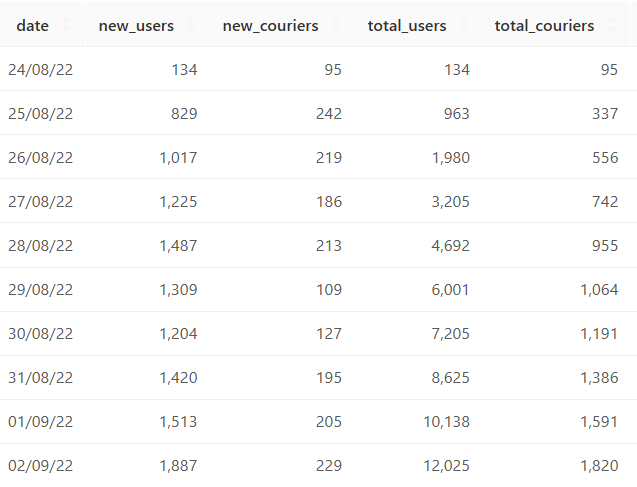

We will build two graphs:
 1. The dynamics of new users and couriers.
 2. The growth of the total number of users and couriers.


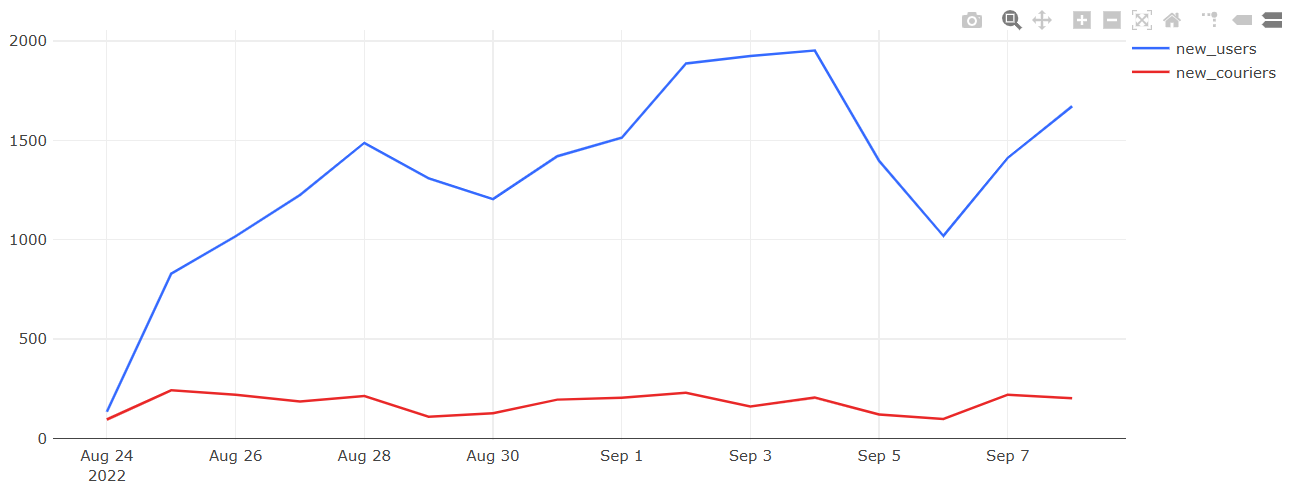

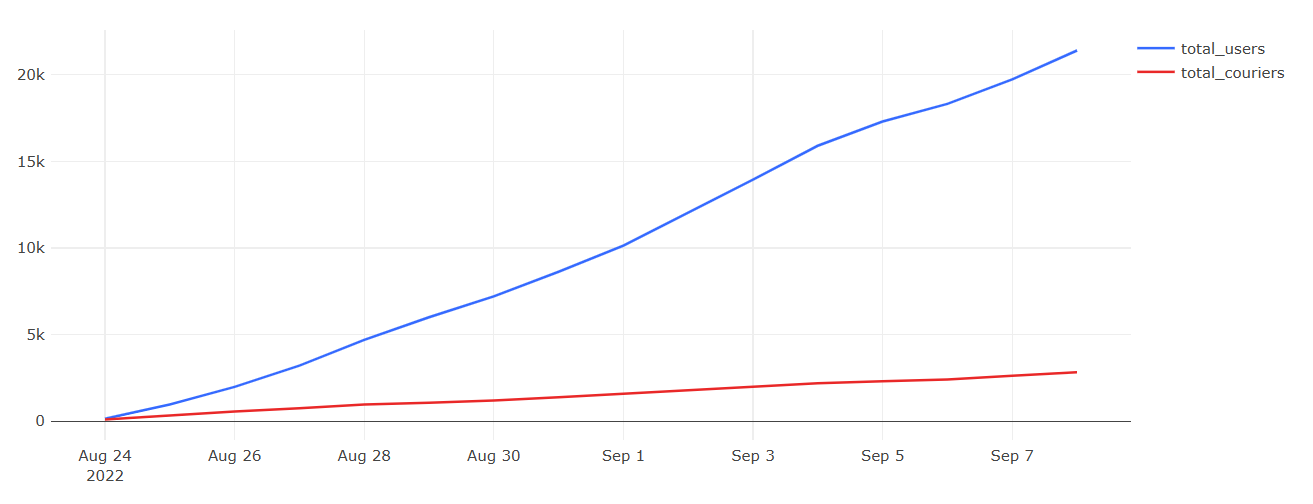

Conclusions
 - The number of new users is growing faster than the number of new couriers.
 - Metrics for couriers are more stable.
 - The line representing new users is fluctuating, with a noticeable peak on September 4, 2022, and a drop on September 6, 2022.
 - Presumably, more users join closer to the end of the week, while fewer join at the beginning.
 - The growth of new users is more rapid compared to the growth of new couriers.

Analyzing the dynamics from the previous step, I found that comparing absolute values is not very convenient. In this step, I will calculate the dynamics of the indicators in relative values.

I will supplement the request from the previous step, and now, for each day presented in the tables user_actions and courier_actions, I will additionally calculate the following indicators:
 - Growth in the number of new users.
 - Growth in the number of new couriers.
 - Growth in the total number of users.
 - Growth in the total number of couriers.

```SQL
SELECT date, new_users, new_couriers, total_users, total_couriers, new_users_change, new_couriers_change,
       ROUND((total_users - LAG(total_users) OVER (ORDER BY date)) * 100.0/ LAG(total_users) OVER  (ORDER BY date), 2) as total_users_growth,
       ROUND((total_couriers - LAG(total_couriers) OVER (ORDER BY date)) * 100.0/ LAG(total_couriers) OVER  (ORDER BY date), 2) as total_couriers_growth
FROM (SELECT start_date as date,
       new_users,
       new_couriers,
       (sum(new_users) OVER (ORDER BY start_date))::int as total_users,
       (sum(new_couriers) OVER (ORDER BY start_date))::int as total_couriers,
       ROUND((new_users - LAG(new_users) OVER (ORDER BY start_date)) * 100.0/ LAG(new_users) OVER  (ORDER BY start_date), 2) as new_users_change,
       ROUND((new_couriers - LAG(new_couriers) OVER (ORDER BY start_date)) * 100.0/ LAG(new_couriers) OVER  (ORDER BY start_date), 2) as new_couriers_change
FROM   (SELECT start_date,
               count(courier_id) as new_couriers
        FROM   (SELECT courier_id,
                       min(time::date) as start_date
                FROM   courier_actions
                GROUP BY courier_id) t1
        GROUP BY start_date) t2
    LEFT JOIN (SELECT start_date,
                      count(user_id) as new_users
               FROM   (SELECT user_id,
                              min(time::date) as start_date
                       FROM   user_actions
                       GROUP BY user_id) t3
               GROUP BY start_date) t4 using (start_date)) t1
```

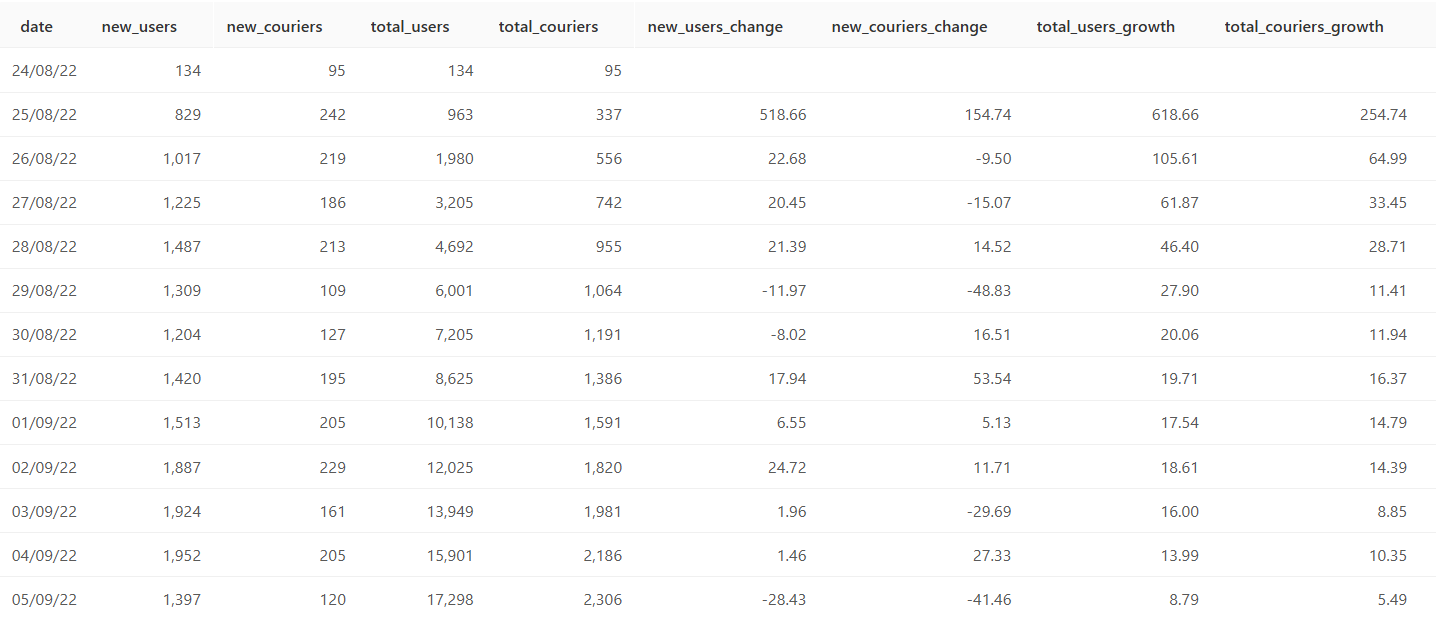

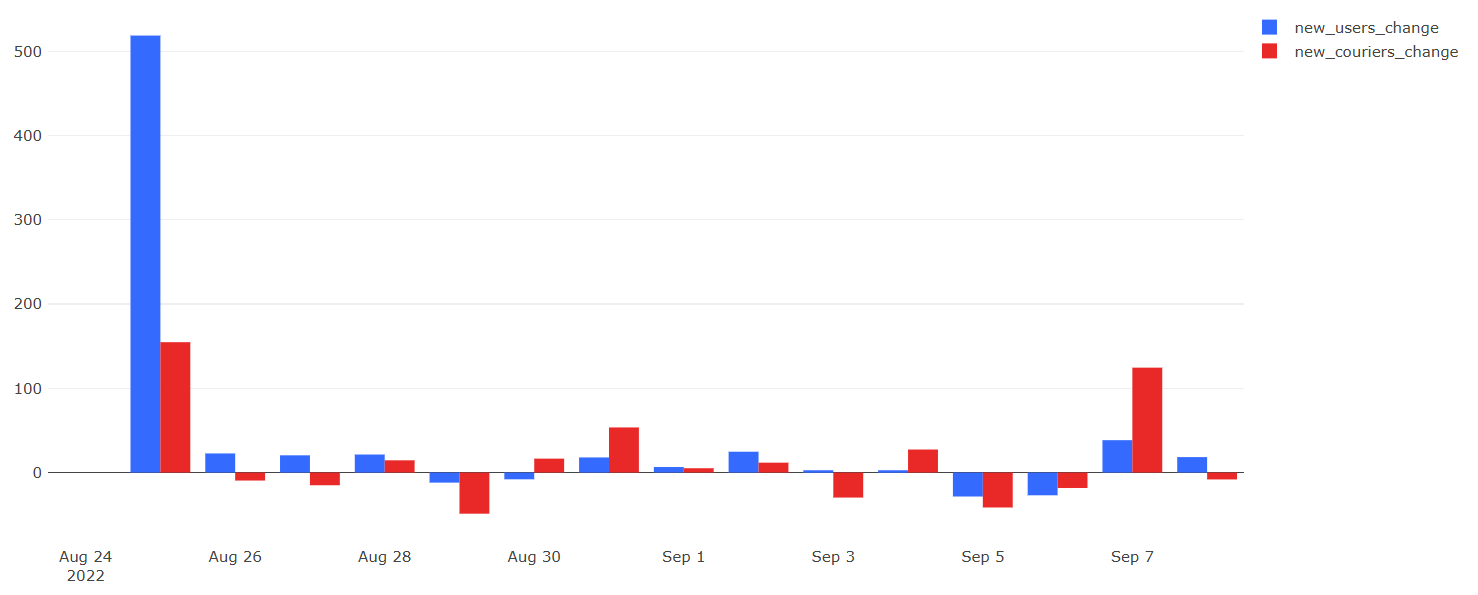

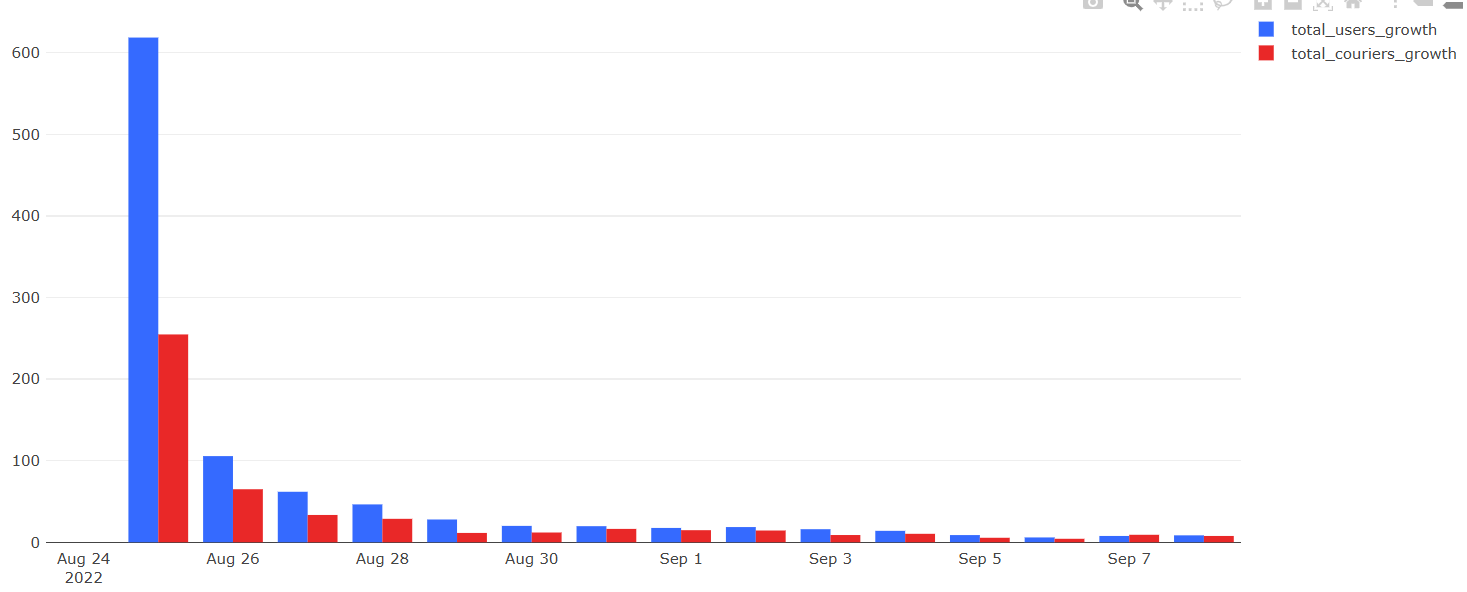

Conclusions:
Analyzing the graphs, we see that the growth rates of the total number of users and couriers are slowing down.
On the dates 31.08, 04.09, and 07.09, the growth in the number of new couriers significantly outpaced the growth rate of new users.
Looking at the graph with relative indicators, we cannot say that the indicator of the number of new couriers is more stable than the indicator of the number of new users.

Now let's look at the audience from a slightly different angle – we will count not just all users, but specifically the part that places and pays for orders in the service.
At the same time, we will find out what share paying users make up of the total number of users on the current day.

We will calculate the following indicators:

- The number of paying users.
- The number of active couriers.
- The share of paying users in the total number of users on the current day.
- The share of active couriers in the total number of couriers on the current day.

We consider as paying users those users who placed at least one order on a given day, which was not subsequently canceled.
We consider couriers active if on a given day they accepted at least one order that was delivered (possibly on the next day) or delivered any order.

```SQL
SELECT date, paying_users, active_couriers,
       ROUND (100*paying_users/total_users::DECIMAL,2) AS paying_users_share,
       ROUND (100*active_couriers/total_couriers::DECIMAL,2) AS active_couriers_share
FROM(
     SELECT time::DATE AS date, COUNT (DISTINCT user_id) FILTER (WHERE action='create_order' AND order_id NOT IN (SELECT order_id FROM user_actions WHERE action='cancel_order')) AS paying_users
     FROM user_actions
     GROUP BY date) AS t1
FULL JOIN
    (SELECT time::DATE AS date, COUNT (DISTINCT courier_id) FILTER (WHERE action='accept_order' AND order_id IN (SELECT order_id FROM courier_actions WHERE action='deliver_order') OR action ='deliver_order') AS active_couriers
     FROM courier_actions
     GROUP BY date) AS t2
USING (date)
FULL JOIN
     (SELECT date, new_users, new_couriers,
             SUM (new_users) OVER (ORDER BY date)::int AS total_users,
             SUM (new_couriers) OVER (ORDER BY date)::int AS total_couriers
      FROM (SELECT date, COUNT (user_id) as new_users
            FROM(
                 SELECT user_id, MIN(time)::DATE as date
                 FROM user_actions
                 GROUP BY user_id) t3
            GROUP BY date) AS t4
      FULL JOIN
           (SELECT date, COUNT (courier_id) as new_couriers
            FROM(
                 SELECT courier_id, MIN(time)::DATE as date
                 FROM courier_actions 
                 GROUP BY courier_id) t5
            GROUP BY date) AS t6
       USING (date)
      )t7
USING (date)
ORDER BY date;
```

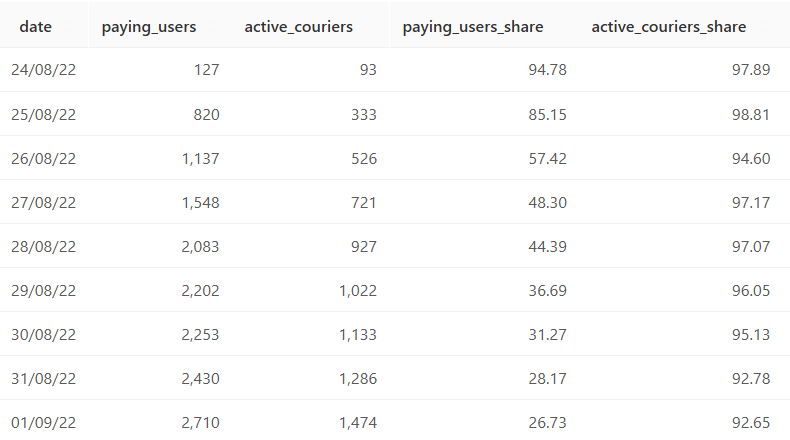

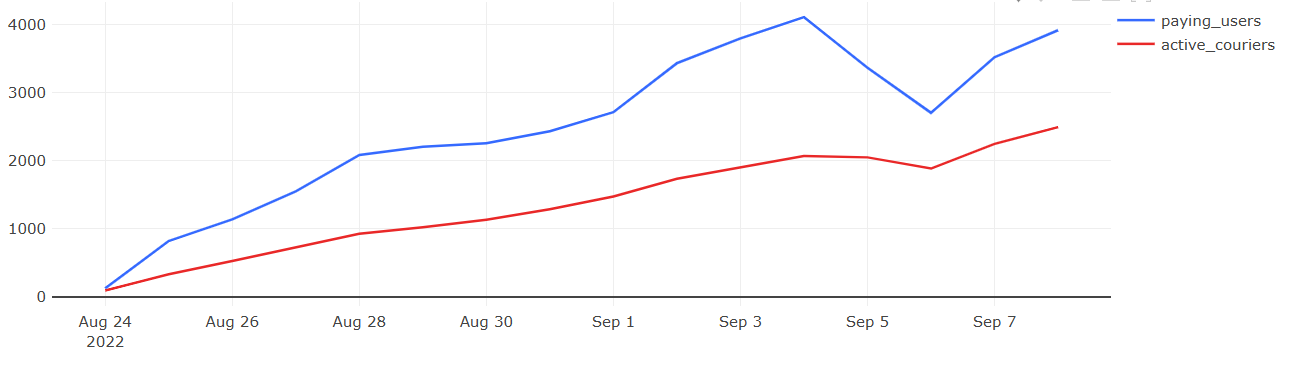

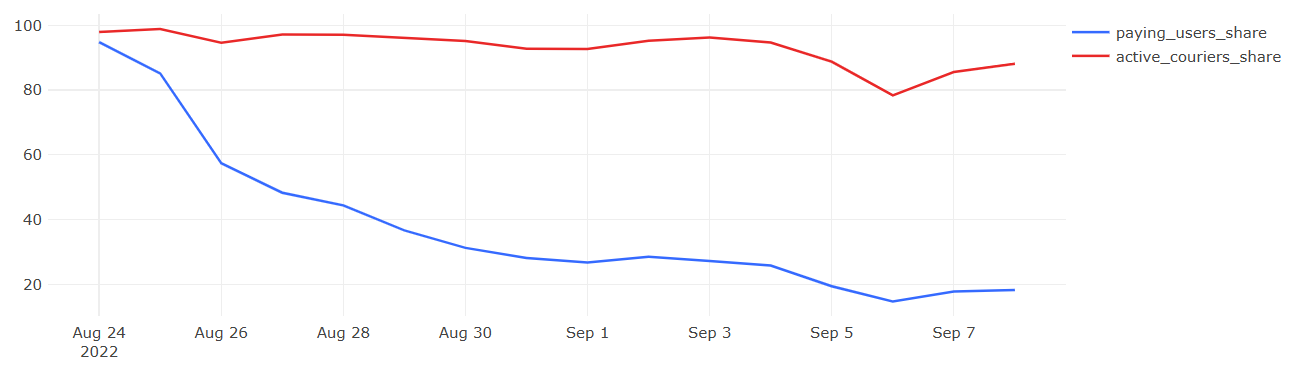

Based on  the upper graph, the absolute numbers of paying users and active couriers are indeed increasing over time.
However, the growth rates differ:

- The number of paying users initially grows, then declines, and then increases again.
- The number of active couriers grows more steadily, without sharp declines.

This suggests that the total number of users and couriers is increasing, but it does not guarantee a linear growth in paying users.

How do the shares of paying users and active couriers behave over time?
The lower graph shows that the share of paying users is decreasing over time, while the share of active couriers remains high and relatively stable.
This behavior can be explained by the fact that the total number of users is growing faster than the number of those who make payments.
This may be due to the attraction of new users who have not yet placed any orders.

The share of active couriers remains at a high level, which may indicate that courier operations are scaling proportionally to demand.
In general, a decline in the share of paying users could be a concerning signal if it is not compensated by overall revenue growth.
However, such dynamics are expected during periods of active user acquisition, as many of them have not yet started making payments.

**Conclusion:**
Absolute figures are growing, but relative metrics (shares) show a decline in paying users, unlike active couriers.
This can be a normal situation if the service is actively attracting new users, 
but it is important to monitor their conversion into paying customers to ensure it does not drop too much.



Now, let's take a closer look at paying users, dig a little deeper, and find out how many paying users place more than one order per day.
After all, it is important for us to understand how most of our users behave—do they open the app just to place a single order, or is our service so good that they are willing to use it multiple times a day?

For each day, we will calculate the following metrics:

- The share of users who made only one order that day out of the total number of paying users.
- The share of users who made multiple orders that day out of the total number of paying users.

```SQL
WITH user_orders AS (
    SELECT 
        user_id,
        time::DATE AS date,
        COUNT(order_id) AS order_count
    FROM user_actions
    WHERE action = 'create_order'
        AND order_id NOT IN (
            SELECT order_id FROM user_actions WHERE action = 'cancel_order'
        )
    GROUP BY user_id, date
),
paying_users_summary AS (
    SELECT 
        date,
        COUNT(DISTINCT user_id) AS total_paying_users
    FROM user_orders
    GROUP BY date
),
one_order_users AS (
    SELECT 
        date,
        COUNT(DISTINCT user_id) AS users_with_1_order
    FROM user_orders
    WHERE order_count = 1
    GROUP BY date
),
few_orders_users AS (
    SELECT 
        date,
        COUNT(DISTINCT user_id) AS users_with_few_orders
    FROM user_orders
    WHERE order_count >=2
    GROUP BY date)
SELECT 
    p.date, 
    ROUND(users_with_1_order::DECIMAL / NULLIF(total_paying_users, 0) * 100, 2) AS single_order_users_share,
    ROUND(users_with_few_orders::DECIMAL / NULLIF(total_paying_users, 0) * 100, 2) AS several_orders_users_share
FROM paying_users_summary p
LEFT JOIN one_order_users o USING (date)
LEFT JOIN few_orders_users f USING (date)
ORDER BY p.date;
```

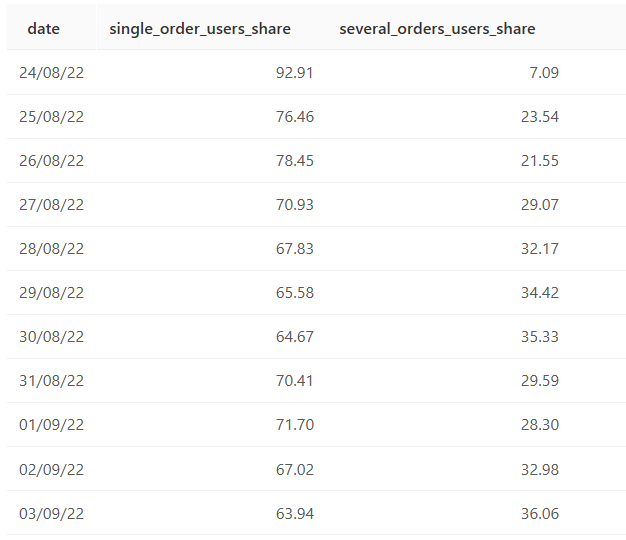

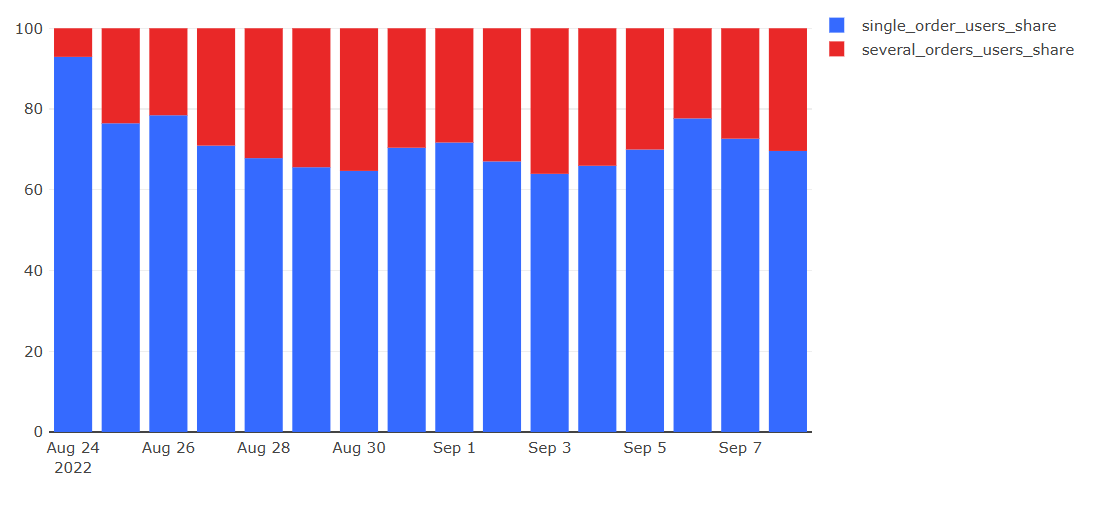

**Conclusions:**

On average, the share of users with multiple orders remains around 20-25%.
We see that the values on the first day differ significantly from the overall picture, so it can be considered an anomaly.

Let's continue analyzing our service and calculate several order-related metrics.

For each day represented in the user_actions table, we will calculate the following indicators:

- The total number of orders.

- The number of first orders (orders placed by users for the first time).

- The number of orders from new users (orders placed by users on the same day they first used the service).

- The share of first orders in the total number of orders (share of point 2 in point 1).

- The share of new user orders in the total number of orders (share of point 3 in point 1).

```SQL
WITH orders AS (
    SELECT time::DATE AS date, COUNT(DISTINCT order_id) AS orders
    FROM user_actions
    WHERE action = 'create_order'
          AND order_id NOT IN (
              SELECT order_id FROM user_actions WHERE action = 'cancel_order'
          )
    GROUP BY date
),
first_orders AS (
    SELECT time::DATE AS date, user_id, order_id,
           ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY time::DATE) AS rn
    FROM user_actions
    WHERE action = 'create_order'
          AND order_id NOT IN (
              SELECT order_id FROM user_actions WHERE action = 'cancel_order'
          )
),
new_users_orders AS (
    SELECT date, COUNT(order_id) AS new_users_orders
    FROM (
        SELECT user_id, time::DATE AS date, order_id, action,
               MIN(time::DATE) OVER (PARTITION BY user_id) AS start_date
        FROM user_actions
    ) AS t
    WHERE date = start_date
          AND action = 'create_order'
          AND order_id NOT IN (
              SELECT order_id FROM user_actions WHERE action = 'cancel_order'
          )
    GROUP BY date
)

SELECT o.date, 
       o.orders, 
       COUNT(DISTINCT f.user_id) AS first_orders, 
       COALESCE(n.new_users_orders, 0) AS new_users_orders,
       ROUND(COUNT(DISTINCT f.user_id) * 100.0 / NULLIF(o.orders, 0), 2) AS first_orders_share,
       ROUND(COALESCE(n.new_users_orders, 0) * 100.0 / NULLIF(o.orders, 0), 2) AS new_users_orders_share
FROM orders o
LEFT JOIN first_orders f ON o.date = f.date AND f.rn = 1
LEFT JOIN new_users_orders n ON o.date = n.date
GROUP BY o.date, o.orders, n.new_users_orders
ORDER BY o.date;
```

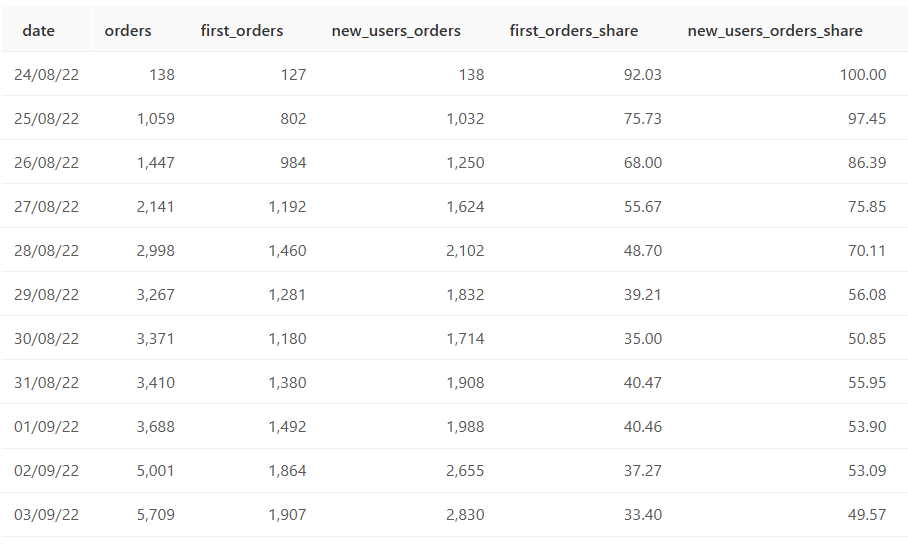

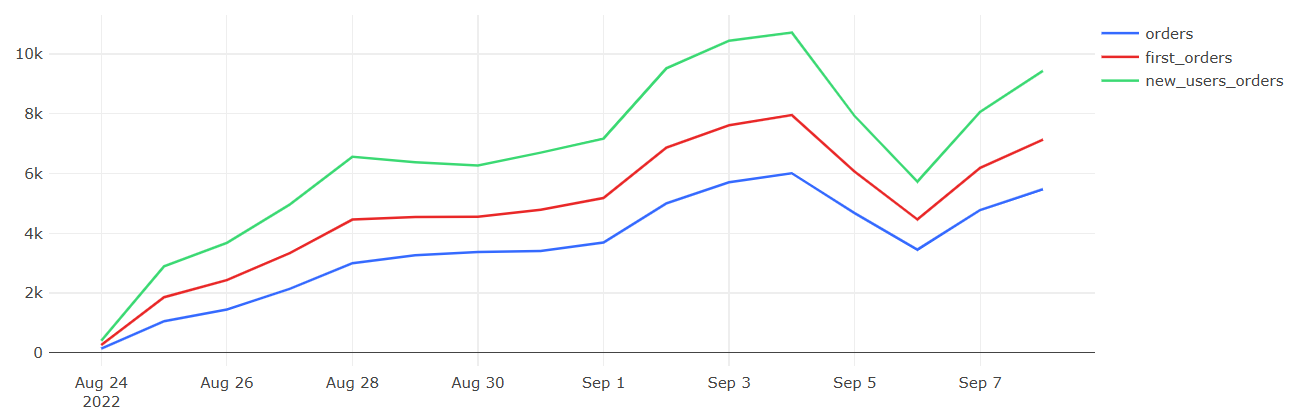

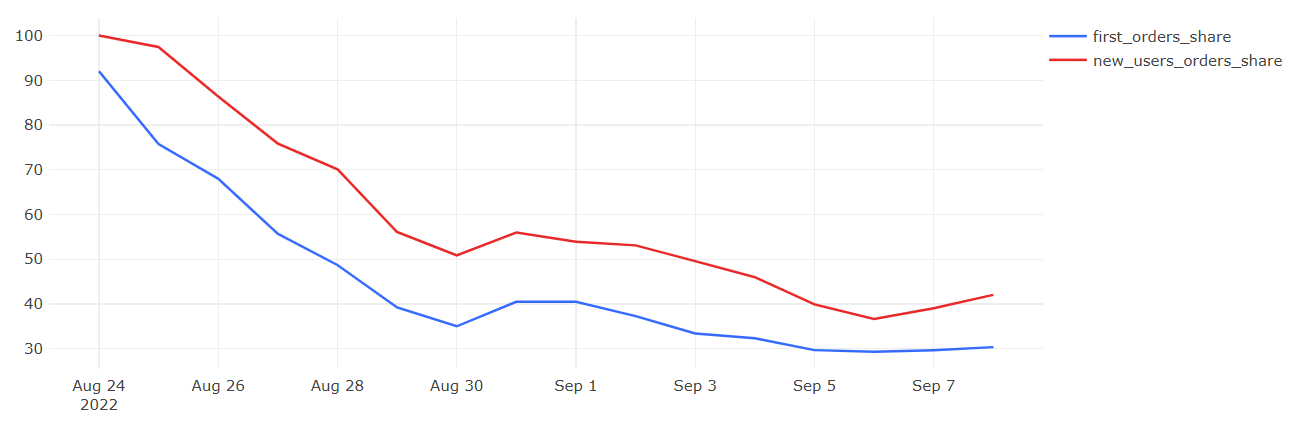

**Conclusions:**

- The first graph shows that the total number of orders demonstrates steady growth from August 24 to September 7, despite minor fluctuations.

- The number of first orders and orders from new users is also increasing, following the overall trend.

- This indicates that the growth in total orders is accompanied by an increase in new customers and their first orders.

The first graph also displays the shares of first orders and orders from new users. These values decrease over time,
although they were very high at the beginning of the period. This is expected: as the customer base expands, new users make up a smaller share of total orders.

**Pattern of Dynamics**
This trend appears logical: at the start of the service, the share of new users and their first orders is high,
but over time, the base of regular customers grows, and they begin to account for the majority of orders.

**Future Outlook**
- In absolute terms, the number of orders, first orders, and orders from new users is likely to continue growing if the service keeps attracting new customers.
- In relative terms, the shares of new users and first orders will likely continue to decline as the proportion of repeat orders increases.

Thus, in the long run, it will be important for the service to retain customers and encourage them to place repeat orders.